In [1]:
import subprocess
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import csv
%matplotlib inline

# restore some of the defaults that I believe are changed by the inline magic
mpl.rcParams.update(mpl.rcParamsDefault)

from matplotlib import rcParams
rcParams['font.size'] = 17

# Small font size for the legend
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('x-small')

In [2]:
def get_last_row(csv_filename):
    '''
    Function which returns just the last row of a CSV file.  We have to
    read every line of the file, there was no stackoverflow example of
    reading just the last line.
    http://stackoverflow.com/questions/20296955/reading-last-row-from-csv-file-python-error
    '''
    with open(csv_filename, 'r') as f:
        lastrow = None
        for row in csv.reader(f):
            if (row != []): # skip blank lines at end of file.
                lastrow = row
        return lastrow


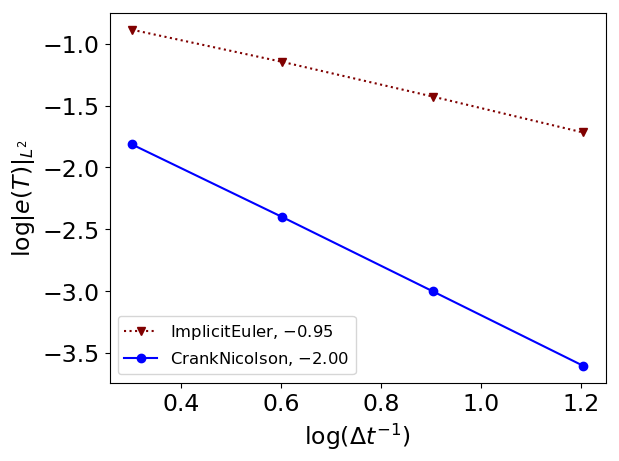

In [3]:
x, y, t = sp.symbols('x y t')

exact_soln = t*t*t*((x*x)+(y*y))

forcing_function = sp.diff(exact_soln,t) + \
                   sp.diff(exact_soln,x) - \
                   sp.diff(sp.diff(exact_soln, x),x) - \
                   sp.diff(sp.diff(exact_soln, y),y)

# Sub ** for ^ so the function parser doesn't cough
exact_soln = str(exact_soln).replace('**','^')
forcing_function = str(forcing_function).replace('**','^')

num_runs = 4
dts = np.asarray([1. / 2**i for i in range(1,num_runs+1)])

# Lists of TimeIntegrators to plot.
time_integrators = ['ImplicitEuler', 'CrankNicolson']

# Plot colors
colors = ['maroon', 'blue']

# Plot line markers
markers = ['v', 'o']

# Plot line styles
linestyles = [':', '-']

fig = plt.figure()
ax1 = fig.add_subplot(111)

for i in range(len(time_integrators)):
    time_integrator = time_integrators[i]
    
    results = np.zeros(len(dts))
    for index,dt in enumerate(dts):
        args = ['../../../../navier_stokes-opt',
                '--allow-test-objects',
               '-i',
               'stabilized-time-convergence-study.i',
               'Functions/forcing_function/value=' + str(forcing_function),
               'Functions/exact_soln/value=' + str(exact_soln),
               'Executioner/dt=' + str(dt),
               'Executioner/TimeIntegrator/type=' + time_integrator]
        subprocess.run(args)
        results[index] = get_last_row('stabilized-time-convergence-study_out.csv')[1]

    # Make plot
    xdata = np.log10(np.reciprocal(dts))
    ydata = np.log10(results)

    # Compute linear fit of last three points.
    start_fit = len(xdata) - 3
    end_fit = len(xdata)
    fit = np.polyfit(xdata[start_fit:end_fit], ydata[start_fit:end_fit], 1)

    ax1.plot(xdata, ydata, label=time_integrator + ", $" + "{:.2f}".format(fit[0]) + "$",
         color=colors[i], marker=markers[i], linestyle=linestyles[i])


# Set up the axis labels.
ax1.set_xlabel('$\log (\Delta t^{-1})$')
ax1.set_ylabel('$\log \|e(T)\|_{L^2}$')

# Add a legend
plt.legend(loc='lower left', prop=fontP)

plt.show()